In [ ]:
%%capture
!wget https://www.dropbox.com/s/myqjozyhxiionc3/dataset.zip

In [ ]:
from zipfile import ZipFile
zip = ZipFile('dataset.zip')
zip.extractall()

In [ ]:
import os
import pandas as pd

df = pd.DataFrame(columns=['review','sentiment'])

path = '/content/dataset/'



for directory in os.listdir(path):
  counter = 0
  print(directory)
  if os.path.isdir(path + directory):
    for filename in os.listdir(path + directory):
      if counter != 15000:
        with open(os.path.join(path + directory + '/', filename)) as f:
          review = f.read()
          current_df = pd.DataFrame({'review': [review], 'sentiment': directory})
          df = df._append(current_df, ignore_index=True)
          counter+=1

neu
pos
neg


In [ ]:
df.sample(10)

,review,sentiment
13467,"Не знаю, что заставило меня смотреть этот филь...",neu
11110,"Фильм рассказывает о фотографах, о людях котор...",neu
35561,"В стародавние времена, когда Николай Светлаков...",neg
12080,Изначально посмотреть данный фильм мне хотелос...,neu
30597,"Затерянные в космосе сериал от Netflix, являющ...",neg
43391,"Что может быть лучше, чем провести вечер за пр...",neg
35886,Кипр - древнейший гео-социо-исторический камен...,neg
14029,"Тот, кто жертвует своими желаниями ради высшей...",neu
33083,Пора тебе запачкать ручки…\n\n(примерно 50-ая ...,neg
24914,"Мария Хосе, Маркус и Хайме – студенты Академии...",pos


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.shape

(45000, 2)

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
import tensorflow as tf

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     45000 non-null  object
 1   sentiment  45000 non-null  object
dtypes: object(2)
memory usage: 703.2+ KB


In [ ]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,Начали с супругой смотреть со второго сезона. ...,1
1,"Фильм на самом деле наплохой, вполне в духе Ма...",1
2,Образ Кабирии показан на экране весьма трагичн...,2
3,Проблема отцов и детей освещается в современно...,2
4,Как всё начиналось?\n\n1977г. Монреаль. В это ...,2


In [ ]:
df.sentiment.unique()

array([1, 2, 0])

In [ ]:
df["sentiment"].value_counts()

sentiment
1    15000
2    15000
0    15000
Name: count, dtype: int64

In [ ]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^А-ЯЁа-яёA-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "")
    df[content_field] = df[content_field].str.replace(r'[^\w\s]', '')
    df[content_field] = df[content_field].str.lower()
    return df

In [ ]:
standardize_text(df,"review")

,review,sentiment
0,начали с супругой смотреть со второго сезона. ...,1
1,"фильм на самом деле наплохой, вполне в духе ма...",1
2,образ кабирии показан на экране весьма трагичн...,2
3,проблема отцов и детей освещается в современно...,2
4,как всё начиналось?\n\n1977г. монреаль. в это ...,2
...,...,...
44995,"есть фильмы, их не много, но они заставляют ва...",2
44996,фильм обязан был стать сенсацией в мире отечес...,1
44997,м. найт шьямалан - особенный и неординарный ре...,1
44998,"говорят, что, клин клином вышибают. в данном а...",2


In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
lemmatizer=WordNetLemmatizer()
corpus = []
for i in range(0,len(df)):
    review = re.sub('[^а-яёА-ЯЁ]', ' ', df['review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('russian'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X = tfidf.fit_transform(corpus)
y = df["sentiment"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array([0, 2, 1, 0, 0])

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3435
           1       0.41      0.58      0.48      2124
           2       0.77      0.68      0.72      3441

    accuracy                           0.66      9000
   macro avg       0.66      0.65      0.65      9000
weighted avg       0.70      0.66      0.67      9000

Accuracy Score of SVC: 65.8 %


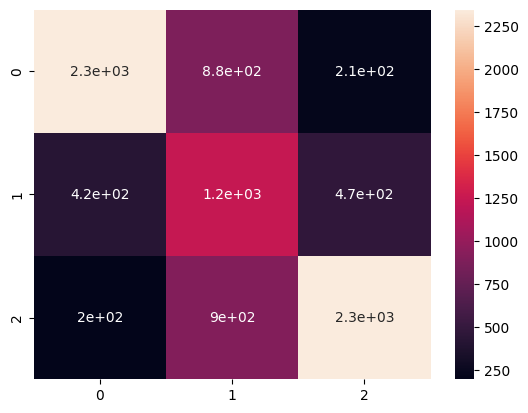

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True)
print(report)
print("Accuracy Score of SVC:", acc*100,"%")